# Import neccesary headers

In [6]:
import tensorflow as tf
import pathlib
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import time
from tensorflow import keras
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import random

# Mount Google Drive

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

# Function to Process Data

In [8]:
def preprocess_data(dataset, window_size, overlap):
    data = []
    labels = []
    for i in range(0, len(dataset) - window_size, overlap):
        sensor_1 = dataset['Sensor 1'].values[i:i+window_size]
        sensor_2 = dataset['Sensor 2'].values[i:i+window_size]
        sensor_3 = dataset['Sensor 3'].values[i:i+window_size]
        label = stats.mode(dataset['Emotion'][i:i+window_size])
        label = label[0][0]
        data.append([sensor_1, sensor_2, sensor_3, label])
#         labels.append(label)
    return data

In [9]:
def build_sub_dataset(dataset):
    data_X = []
    data_Y = []
    for i in range(len(dataset)):
        data_X.append(dataset[i][:3])
        data_Y.append(dataset[i][3])
    return data_X, data_Y

In [10]:
def build_dataset(folder, window_size, overlap):
    fileList = list(os.listdir(folder))
    data_X = []
    data_Y = []
#     print(folder)
    print(fileList)
    for i,file in enumerate(fileList):
#         print(fileList[i])
        df = pd.read_csv(folder+'\\'+file, header=None, names=columns, skiprows=[0,1])
        df.dropna()
        df.query('Emotion != "Nothing"', inplace = True)
#         print(df.count())
        subdata = preprocess_data(df, window_size, overlap)
        random.shuffle(subdata)
        for i in range(len(subdata)):
            data_X.append(subdata[i][:3])
            data_Y.append(subdata[i][3])
#         subdata_X, subdata_Y = build_sub_dataset(subdata)
#         data_X = data_X + subdata_X
#         data_Y = data_Y + subdata_Y
    return data_X, data_Y

# Build the Train, Validation, and Test Datasets

In [11]:
# c=os.listdir('C:\\Users\\toanv\\EMG\\NEWEMG\\Newdata\\data041721')

RANDOM_SEED = 42

columns = ['Emotion', 'Sensor 1', 'Sensor 2', 'Sensor 3']
labels = ['Happy', 'Sad', 'Angry']
# labels = ['No Emotion','Happy', 'Sad', 'Angry']

window_size = 512 # Number of timesteps for each window
num_features = 3 # Number of sensors
overlap = 32 # Number of overlap timesteps between 2 consecutive windows
num_outputs = 3 # Number of Outputs

base = os.getcwd()
print(base)
# folders = ['\\test', '\\train', '\\validation']

train_X, train_Y = build_dataset(base+'\\train', window_size, overlap)
validation_X, validation_Y = build_dataset(base+'\\validation', window_size, overlap)
test_X, test_Y = build_dataset(base+'\\test', window_size, overlap)

C:\Users\toanv\EMG\NEWEMG\Newdata\data041721
['tra1n11 (1).csv', 'tra1n11 (10).csv', 'tra1n11 (11).csv', 'tra1n11 (12).csv', 'tra1n11 (13).csv', 'tra1n11 (2).csv', 'tra1n11 (3).csv', 'tra1n11 (4).csv', 'tra1n11 (5).csv', 'tra1n11 (6).csv', 'tra1n11 (7).csv', 'tra1n11 (8).csv', 'tra1n11 (9).csv', 'train12 (1).csv', 'train12 (10).csv', 'train12 (11).csv', 'train12 (12).csv', 'train12 (2).csv', 'train12 (3).csv', 'train12 (4).csv', 'train12 (5).csv', 'train12 (6).csv', 'train12 (7).csv', 'train12 (8).csv', 'train12 (9).csv', 'train13 (1).csv', 'train13 (10).csv', 'train13 (11).csv', 'train13 (12).csv', 'train13 (13).csv', 'train13 (2).csv', 'train13 (3).csv', 'train13 (4).csv', 'train13 (5).csv', 'train13 (6).csv', 'train13 (7).csv', 'train13 (8).csv', 'train13 (9).csv', 'train2 (1).csv', 'train2 (10).csv', 'train2 (11).csv', 'train2 (12).csv', 'train2 (2).csv', 'train2 (3).csv', 'train2 (4).csv', 'train2 (5).csv', 'train2 (6).csv', 'train2 (7).csv', 'train2 (8).csv', 'train2 (9).csv', 't

# Let's Check the Shape of the Datasets

In [12]:
print('train_dataset: ', np.array(train_X).shape)
print('validation_dataset: ', np.array(validation_X).shape)
print('test_dataset: ', np.array(test_X).shape)

train_dataset:  (57818, 3, 512)
validation_dataset:  (12983, 3, 512)
test_dataset:  (12989, 3, 512)


# Reshape to Feed in the LSTM networks

In [13]:
train_X = np.asarray(train_X,dtype=np.float32).reshape(-1, window_size, num_features)
validation_X = np.asarray(validation_X,dtype=np.float32).reshape(-1, window_size, num_features)
test_X = np.asarray(test_X,dtype=np.float32).reshape(-1, window_size, num_features)

In [14]:
print('train_dataset: ', np.array(train_X).shape)
print('validation_dataset: ', np.array(validation_X).shape)
print('test_dataset: ', np.array(test_X).shape)

train_dataset:  (57818, 512, 3)
validation_dataset:  (12983, 512, 3)
test_dataset:  (12989, 512, 3)


# One-hot Encoding Labels

In [15]:
train_Y =  np.asarray(pd.get_dummies(train_Y), dtype=np.float32)
validation_Y =  np.asarray(pd.get_dummies(validation_Y), dtype=np.float32)
test_Y =  np.asarray(pd.get_dummies(test_Y), dtype=np.float32)


In [16]:
print('train_dataset: ', np.array(train_Y).shape)
print('validation_dataset: ', np.array(validation_Y).shape)
print('test_dataset: ', np.array(test_Y).shape)

train_dataset:  (57818, 3)
validation_dataset:  (12983, 3)
test_dataset:  (12989, 3)


# Let's Double-Check the Shapes of the Datasets

In [17]:
print(train_X.shape, train_Y.shape)
print(validation_X.shape, validation_Y.shape)
print(test_X.shape, test_Y.shape)

(57818, 512, 3) (57818, 3)
(12983, 512, 3) (12983, 3)
(12989, 512, 3) (12989, 3)


# Let's Build the LSTM Model With Some Pre-defined Parameters

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

num_hidden_layers = 128
dropout = 0.2
epochs = 150
batch_size = 128
learning_rate = 1e-8

model = Sequential()

model.add(Conv1D(filters=32, kernel_size=window_size,activation="relu",
                 input_shape=(window_size,num_features)))
model.add(Dropout(dropout))

model.add(LSTM(num_hidden_layers, kernel_regularizer=keras.regularizers.l2(0.01),
               recurrent_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(dropout))

model.add(Dense(num_hidden_layers, activation='relu',
                kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(dropout))

model.add(Dense(num_outputs, activation='softmax', 
                kernel_regularizer=keras.regularizers.l2(0.01)))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: learning_rate * 10**(epoch / 20))
optimizer = keras.optimizers.Adam(lr=learning_rate)
#model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Setup a Learning Scheduler to Find a Good Learning Rate

In [19]:
history=model.fit(train_X, train_Y, epochs=epochs, callbacks=[lr_schedule],
                  batch_size=batch_size, shuffle=True)

Train on 57818 samples
Epoch 1/150
57818/57818 [==============================] - 9s 160us/sample - loss: 4.3130 - accuracy: 0.3363
Epoch 2/150
57818/57818 [==============================] - 2s 33us/sample - loss: 4.3125 - accuracy: 0.3367
Epoch 3/150
57818/57818 [==============================] - 2s 33us/sample - loss: 4.3116 - accuracy: 0.3433
Epoch 4/150
57818/57818 [==============================] - 2s 33us/sample - loss: 4.3108 - accuracy: 0.3476
Epoch 5/150
57818/57818 [==============================] - 2s 33us/sample - loss: 4.3098 - accuracy: 0.3510
Epoch 6/150
57818/57818 [==============================] - 2s 33us/sample - loss: 4.3088 - accuracy: 0.3558
Epoch 7/150
57818/57818 [==============================] - 2s 33us/sample - loss: 4.3077 - accuracy: 0.3594
Epoch 8/150
57818/57818 [==============================] - 2s 35us/sample - loss: 4.3061 - accuracy: 0.3702
Epoch 9/150
57818/57818 [==============================] - 2s 34us/sample - loss: 4.3047 - accuracy: 0.3768
Epoc

(1e-08, 100.0, 0.0, 1.0)

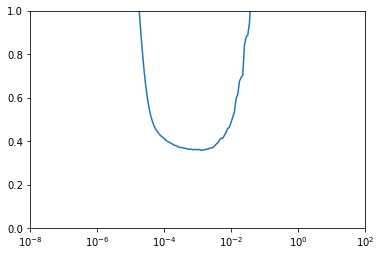

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e2, 0, 1])

(1e-08, 100.0, 0.0, 1.0)

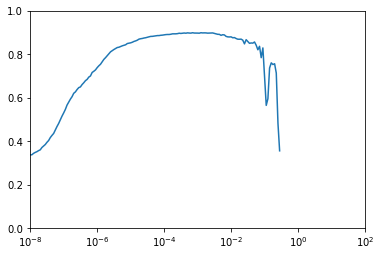

In [21]:
plt.semilogx(history.history["lr"], history.history["accuracy"])
plt.axis([1e-8, 1e2, 0, 1])

# Build the Model: Conv1D+LSTM

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

num_hidden_layers = 128
dropout = 0.3
batch_size = 64
train_epochs = 500

# Best learning_rate so far is:
    # 1e-3: 70% accuracy
    # 2.5e-3: 80% accuracy

# learning_rate = 0.00025
learning_rate = 1e-4
L2_Reg = 0.0015

model = Sequential()

model.add(Conv1D(filters=32, kernel_size=window_size,activation="relu",
                 input_shape=(window_size,num_features)))
model.add(Dropout(dropout))

model.add(LSTM(num_hidden_layers, kernel_regularizer=keras.regularizers.l2(L2_Reg),
               recurrent_regularizer=keras.regularizers.l2(L2_Reg)))
model.add(Dropout(dropout))

model.add(Dense(num_hidden_layers, activation='relu',
                kernel_regularizer=keras.regularizers.l2(L2_Reg)))
model.add(Dropout(dropout))

model.add(Dense(num_outputs, activation='softmax', 
                kernel_regularizer=keras.regularizers.l2(L2_Reg)))

optimizer = keras.optimizers.Adam(lr=learning_rate)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
# filepath = "ModelWeights-{epoch:.2f}-{val_accuracy:.2f}.hdf5"
# checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, monitor="val_accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             49184     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

# Train the Model With the Chosen Learning Rate

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history=model.fit(train_X, train_Y, epochs=train_epochs,
                  callbacks=[early_stopping], batch_size=batch_size,
                  validation_data=(validation_X, validation_Y), shuffle=True)

Train on 57818 samples, validate on 12983 samples
Epoch 1/500
57818/57818 [==============================] - 7s 115us/sample - loss: 0.7880 - accuracy: 0.8256 - val_loss: 0.6131 - val_accuracy: 0.8614
Epoch 2/500
57818/57818 [==============================] - 4s 77us/sample - loss: 0.5363 - accuracy: 0.8724 - val_loss: 0.5405 - val_accuracy: 0.8688
Epoch 3/500
57818/57818 [==============================] - 4s 73us/sample - loss: 0.4737 - accuracy: 0.8808 - val_loss: 0.4957 - val_accuracy: 0.8683
Epoch 4/500
57818/57818 [==============================] - 4s 77us/sample - loss: 0.4361 - accuracy: 0.8851 - val_loss: 0.4674 - val_accuracy: 0.8711
Epoch 5/500
57818/57818 [==============================] - 4s 77us/sample - loss: 0.4115 - accuracy: 0.8870 - val_loss: 0.4479 - val_accuracy: 0.8733
Epoch 6/500
57818/57818 [==============================] - 5s 78us/sample - loss: 0.3932 - accuracy: 0.8905 - val_loss: 0.4403 - val_accuracy: 0.8718
Epoch 7/500
57818/57818 [========================

# Let's See How the Model Performs

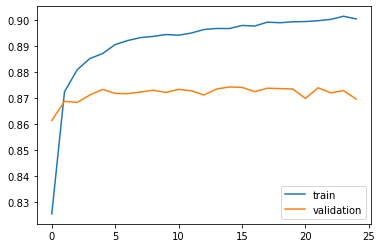

In [24]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

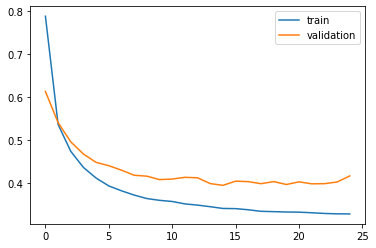

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Let's Do Some Predictions on the Test Dataset

In [26]:
model.evaluate(test_X,test_Y)

12989/12989 [==============================] - 1s 82us/sample - loss: 0.3624 - accuracy: 0.8915


[0.3623790548980553, 0.8915236]

# Plot the Confusion Matrix

In [27]:
predicted_emotions = model.predict(test_X, batch_size=128)
print(test_Y.shape,predicted_emotions.shape)

(12989, 3) (12989, 3)


In [28]:
test_X.shape

(12989, 512, 3)

In [29]:
# labels = ['No Emotion','Happy', 'Sad', 'Angry']
labels = ['Happy', 'Sad', 'Angry']
true_counter = 0
predicted_labels = []
test_labels = []
for i in range(len(predicted_emotions)):
    predicted_labels.append(labels[np.argmax(predicted_emotions[i])])
    test_labels.append(labels[np.argmax(test_Y[i])])
    if labels[np.argmax(predicted_emotions[i])] == labels[np.argmax(test_Y[i])]:
        true_counter = true_counter + 1
print(true_counter/len(test_Y))

0.8915235968896759


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

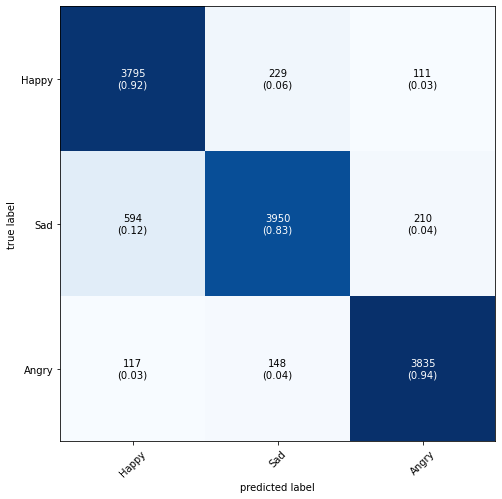

In [30]:
con_matrix = confusion_matrix(test_labels, predicted_labels)
plot_confusion_matrix(conf_mat=con_matrix, class_names=labels, show_normed=True, figsize=(8,8))

# Export to a .h5 file

In [173]:
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)
model.save(export_path_keras)

./1619501904.h5


# Load the Keras `.h5` Model


In [29]:
model = tf.keras.models.load_model('1619496839.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             49184     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [174]:
export_folder = base+'//saved_model'
tf.saved_model.save(model,export_folder)

INFO:tensorflow:Assets written to: C:\Users\toanv\EMG\NEWEMG\Newdata\data041721//saved_model\assets


# The parts below should be done in Google Colab as Jupyter Notebook doesn'y support tflite

# Convert the SavedModel to TFLite

In [176]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_folder)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path(base+'//model.tflite')
tflite_model_file.write_bytes(tflite_model)

ConverterError: See console for info.
2021-04-27 00:46:25.969618: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
2021-04-27 00:46:28.680518: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2021-04-27 00:46:28.682216: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2021-04-27 00:46:28.701874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 3.00GiB deviceMemoryBandwidth: 178.99GiB/s
2021-04-27 00:46:28.701897: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
2021-04-27 00:46:28.705672: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_10.dll
2021-04-27 00:46:28.708722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_10.dll
2021-04-27 00:46:28.709909: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library curand64_10.dll
2021-04-27 00:46:28.713180: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusolver64_10.dll
2021-04-27 00:46:28.715433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusparse64_10.dll
2021-04-27 00:46:28.721679: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudnn64_7.dll
2021-04-27 00:46:28.721795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-04-27 00:46:29.223644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-04-27 00:46:29.223663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-04-27 00:46:29.223669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-04-27 00:46:29.223819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 1941 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1)
2021-04-27 00:46:29.234211: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListFromTensor
2021-04-27 00:46:29.234243: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2021-04-27 00:46:29.234272: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListReserve
2021-04-27 00:46:29.234282: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2021-04-27 00:46:29.234301: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: While
2021-04-27 00:46:29.234317: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2021-04-27 00:46:29.234323: I tensorflow/lite/toco/import_tensorflow.cc:193] Unsupported data type in placeholder op: 21
2021-04-27 00:46:29.234333: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: TensorListStack
2021-04-27 00:46:29.235052: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Removing unused ops: 38 operators, 79 arrays (0 quantized)
2021-04-27 00:46:29.235561: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before general graph transformations: 38 operators, 79 arrays (0 quantized)
2021-04-27 00:46:29.236405: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 1: 22 operators, 65 arrays (0 quantized)
2021-04-27 00:46:29.236829: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 2: 20 operators, 62 arrays (0 quantized)
2021-04-27 00:46:29.237223: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After general graph transformations pass 3: 11 operators, 45 arrays (0 quantized)
2021-04-27 00:46:29.237470: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Group bidirectional sequence lstm/rnn: 11 operators, 45 arrays (0 quantized)
2021-04-27 00:46:29.237648: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before dequantization graph transformations: 11 operators, 45 arrays (0 quantized)
2021-04-27 00:46:29.237833: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Identify nearest upsample.: 11 operators, 45 arrays (0 quantized)
2021-04-27 00:46:29.238143: I tensorflow/lite/toco/allocate_transient_arrays.cc:345] Total transient array allocated size: 6272 bytes, theoretical optimal value: 6272 bytes.
2021-04-27 00:46:29.238246: I tensorflow/lite/toco/toco_tooling.cc:471] Number of parameters: 148663
2021-04-27 00:46:29.238587: E tensorflow/lite/toco/toco_tooling.cc:498] We are continually in the process of adding support to TensorFlow Lite for more ops. It would be helpful if you could inform us of how this conversion went by opening a github issue at https://github.com/tensorflow/tensorflow/issues/new?template=40-tflite-op-request.md
 and pasting the following:

Some of the operators in the model are not supported by the standard TensorFlow Lite runtime. If those are native TensorFlow operators, you might be able to use the extended runtime by passing --enable_select_tf_ops, or by setting target_ops=TFLITE_BUILTINS,SELECT_TF_OPS when calling tf.lite.TFLiteConverter(). Otherwise, if you have a custom implementation for them you can disable this error with --allow_custom_ops, or by setting allow_custom_ops=True when calling tf.lite.TFLiteConverter(). Here is a list of builtin operators you are using: CONV_2D, FULLY_CONNECTED, RESHAPE, SOFTMAX, STRIDED_SLICE. Here is a list of operators for which you will need custom implementations: TensorListFromTensor, TensorListReserve, TensorListStack, While.
Traceback (most recent call last):
  File "C:\Users\toanv\anaconda3\envs\tensorflow\Scripts\toco_from_protos-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\toanv\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\lite\toco\python\toco_from_protos.py", line 93, in main
    app.run(main=execute, argv=[sys.argv[0]] + unparsed)
  File "C:\Users\toanv\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\platform\app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "C:\Users\toanv\anaconda3\envs\tensorflow\lib\site-packages\absl\app.py", line 300, in run
    _run_main(main, args)
  File "C:\Users\toanv\anaconda3\envs\tensorflow\lib\site-packages\absl\app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "C:\Users\toanv\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\lite\toco\python\toco_from_protos.py", line 56, in execute
    enable_mlir_converter)
Exception: We are continually in the process of adding support to TensorFlow Lite for more ops. It would be helpful if you could inform us of how this conversion went by opening a github issue at https://github.com/tensorflow/tensorflow/issues/new?template=40-tflite-op-request.md
 and pasting the following:

Some of the operators in the model are not supported by the standard TensorFlow Lite runtime. If those are native TensorFlow operators, you might be able to use the extended runtime by passing --enable_select_tf_ops, or by setting target_ops=TFLITE_BUILTINS,SELECT_TF_OPS when calling tf.lite.TFLiteConverter(). Otherwise, if you have a custom implementation for them you can disable this error with --allow_custom_ops, or by setting allow_custom_ops=True when calling tf.lite.TFLiteConverter(). Here is a list of builtin operators you are using: CONV_2D, FULLY_CONNECTED, RESHAPE, SOFTMAX, STRIDED_SLICE. Here is a list of operators for which you will need custom implementations: TensorListFromTensor, TensorListReserve, TensorListStack, While.




# Download the Tensorflow Lite Model to Local Disk

In [ ]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

try:
  from google.colab import files
  files.download('model.tflite')
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>